# SHAP

In [184]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import calendar 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [185]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

## 날짜 변경

In [186]:
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [187]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second

In [188]:

def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

#apply() 내장함수는 split(),map(),join(),filter()등 과 함꼐 필수적으로 숙지해야 할 함수이다.
train['season'] = train.month.apply(badToRight)

In [189]:
train["dayofweek"] = train["datetime"].dt.dayofweek


In [190]:
#우리가 가진 column들 중 값들이 일정하고 정해져있다면 category로 변경해주고
#필요하지 않은 column들은 이제 버린다.
categorizational_columns = ['holiday','season','weather','workingday','year','month','day','hour','dayofweek']
drop_columns = ['datetime','casual','registered','count','minute','second']


In [191]:
#categorical하게 변환
for col in categorizational_columns:
    train[col] = train[col].astype('category')


In [192]:
train.dayofweek = train.dayofweek.astype('category')
train.dayofweek.cat.categories = ['5','1','6','0','4','2','3']


## Feature Engeenring

In [193]:
from sklearn.ensemble import RandomForestRegressor

#Windspeed가 0인 데이터프레임
windspeed_0 = train[train.windspeed == 0]
#Windspeed가 0이 아닌 데이터프레임
windspeed_Not0 = train[train.windspeed != 0]

#Windspeed가 0인 데이터 프레임에 투입을 원치 않는 컬럼을 배제
windspeed_0_df = windspeed_0.drop(['windspeed','casual','registered','count','datetime'],axis=1)

#Windspeed가 0이 아닌 데이터 프레임은 위와 동일한 데이터프레임을 형성하고 학습시킬 Windspeed Series를 그대로 둠
windspeed_Not0_df = windspeed_Not0.drop(['windspeed','casual','registered','count','datetime'],axis=1)
windspeed_Not0_series = windspeed_Not0['windspeed'] 

#모델에 0이 아닌 데이터프레임과 결과값을 학습
rf = RandomForestRegressor()
rf.fit(windspeed_Not0_df,windspeed_Not0_series)
#학습된 모델에 Windspeed가 0인 데이터프레임의 Windspeed를 도출
predicted_windspeed_0 = rf.predict(windspeed_0_df)
#도출된 값을 원래의 데이터프레임에 삽입
windspeed_0['windspeed'] = predicted_windspeed_0

In [194]:
#시간별 정렬을 위해 string type의 datetime을 datetime으로 변환
train.datetime = pd.to_datetime(train.datetime,errors='coerce')


In [195]:
#합쳐진 데이터를 datetime순으로 정렬
train = train.sort_values(by=['datetime'])


In [196]:
test = train.loc[ (train["year"] == 2012) & (train["month"].isin([9,10,11,12]) ) ]
#vali = train.loc[ (train["year"] == 2012) & (train["month"].isin([7,8]) ) ]
#train = train.loc[ ((train["year"] == 2012) & (train["month"].isin([1,2,3,4,5,6]))) | (train["year"] == 2011)]
train = train.loc[ ((train["year"] == 2012) & (train["month"].isin([1,2,3,4,5,6,7,8]))) | (train["year"] == 2011)]


In [197]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [198]:
#데이터 훈련시 집어 넣게 될 각각의 결과 값들
#datetimecol = test['datetime']
yLabels = train['count'] #count
#yLabelsRegistered = train['registered'] #등록된 사용자
#yLabelsCasual = train['casual'] #임시 사용자
#yLabels_vali = vali['count']
yLabels_test = test['count'] #y값


In [199]:
yLabelslog = np.log1p(yLabels)
#yLabelslog_vali = np.log1p(yLabels_vali)
yLabelslog_test = np.log1p(yLabels_test)


In [200]:
#필요 없는 column들을 버린 후의 훈련과 테스트 셋
train = train.drop(drop_columns,axis=1)
#vali = vali.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)

## Model ( LGBM, RandomForest)

In [27]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [29]:
model_lgb.fit(train, yLabelslog)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [34]:
lgb_test_pred = np.exp(model_lgb.predict(test))
print('RMSE Value for RandomForest = ',rmse(lgb_test_pred,yLabels_test))

RMSE Value for RandomForest =  115.84211409736122


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rmse_scorer = metrics.make_scorer(rmse,greater_is_better=True)
rf_params = {'n_estimators':[1,10,100]}

grid_rf = GridSearchCV(rf,rf_params,scoring=rmse_scorer,cv=5)
grid_rf.fit(train,yLabelslog)
preds = grid_rf.predict(test)

In [41]:
lgb_test_pred2 = np.exp(preds)
print('RMSE Value for RandomForest = ',rmse(lgb_test_pred2,yLabels_test))

RMSE Value for RandomForest =  93.83232138362624


In [59]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb_params={'max_depth':range(1,15,1),'n_estimators':[1,10,100]}
grid_gb=GridSearchCV(gb,gb_params,scoring=rmse_scorer,cv=4)
grid_gb.fit(train,yLabelslog)
preds3 = grid_gb.predict(test)

In [61]:
lgb_test_pred3 = np.exp(preds3)
print('RMSLE Value for GradientBoosting = ',rmse(lgb_test_pred3,yLabels_test))

RMSLE Value for GradientBoosting =  79.54003117450104


## SHAP 

In [44]:
import shap
import js2py

In [62]:
# load JS visualization code to notebook
shap.initjs()

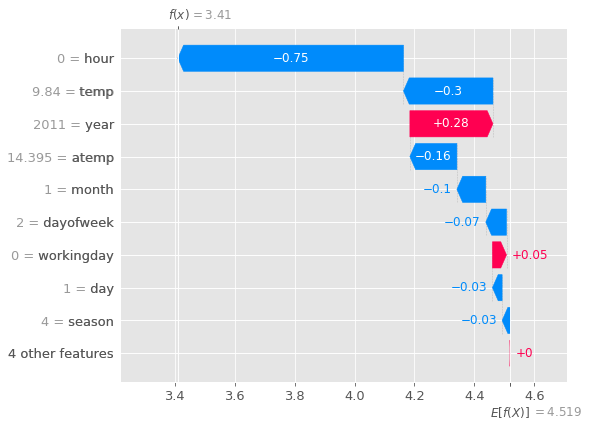

In [75]:
explainer = shap.Explainer(model_lgb)
shap_values = explainer(train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [76]:
shap.plots.force(shap_values[0])


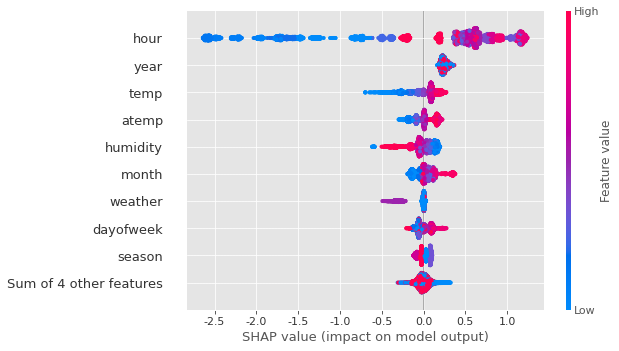

In [77]:
shap.plots.beeswarm(shap_values)


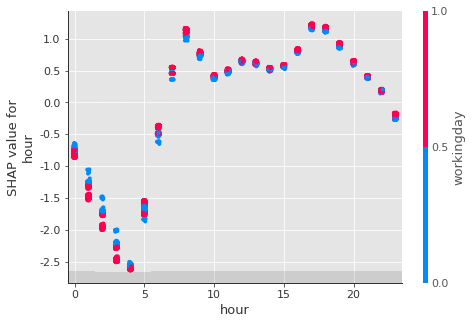

In [78]:
shap.plots.scatter(shap_values[:,"hour"], color=shap_values)


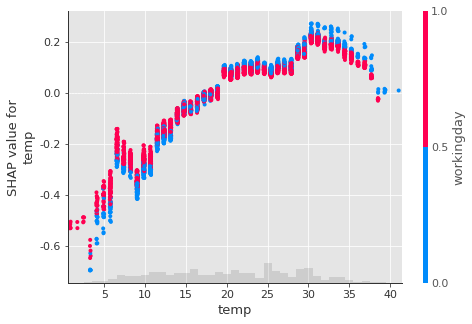

In [79]:
shap.plots.scatter(shap_values[:,"temp"], color=shap_values)


# interpretML

In [96]:
marginal.visualize

<bound method MarginalExplanation.visualize of <interpret.data.response.MarginalExplanation object at 0x105c36a00>>

In [129]:
marginal.data()

{'type': 'hist',
 'density': {'names': array([  1. ,  45.8,  90.6, 135.4, 180.2, 225. , 269.8, 314.6, 359.4,
         404.2, 449. , 493.8, 538.6, 583.4, 628.2, 673. , 717.8, 762.6,
         807.4, 852.2, 897. ]),
  'scores': array([2434, 1143,  999,  913,  763,  591,  511,  372,  331,  230,  202,
          149,  123,   87,   65,   53,   30,   22,   30,   15])},
 'X': array([[ 9.84  , 14.395 , 81.    ,  0.    ],
        [ 9.02  , 13.635 , 80.    ,  0.    ],
        [ 9.02  , 13.635 , 80.    ,  0.    ],
        ...,
        [25.42  , 29.545 , 78.    ,  6.0032],
        [25.42  , 29.545 , 78.    , 11.0014],
        [25.42  , 29.545 , 73.    ,  0.    ]]),
 'y': array([ 16,  40,  32, ..., 190,  56,  46])}

In [201]:
from interpret import show
from interpret.data import Marginal
marginal = Marginal().explain_data(train[['temp','atemp','humidity','windspeed']], yLabels, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7828/5036012160/ -->

In [202]:
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
ebm2 = ExplainableBoostingRegressor(random_state=1111)
ebm2.fit(train, yLabels)  


ExplainableBoostingRegressor(feature_names=['season', 'holiday', 'workingday',
                                            'weather', 'temp', 'atemp',
                                            'humidity', 'windspeed', 'year',
                                            'month', 'day', 'hour', 'dayofweek',
                                            'workingday x hour', 'year x hour',
                                            'temp x hour', 'atemp x hour',
                                            'month x hour', 'season x hour',
                                            'hour x dayofweek',
                                            'workingday x humidity',
                                            'humidity x year',
                                            'weather x hour'],
                             feature_types=['continuous', 'categorical',
                                            'categorical', 'continuous',
                                            'continuou

In [203]:
from interpret import show
from interpret.perf import RegressionPerf

ebm_perf2 = RegressionPerf(ebm2.predict).explain_perf(test, yLabels_test, name='EBM')
show(ebm_perf2)


<!-- http://127.0.0.1:7828/5059297440/ -->

In [204]:
ebm_global2 = ebm2.explain_global(name='EBM')
show(ebm_global2)

<!-- http://127.0.0.1:7828/5063489664/ -->

In [205]:
ebm_local2 = ebm2.explain_local(train[:100], yLabels[:100], name='EBM')
show(ebm_local2)

<!-- http://127.0.0.1:7828/5063644592/ -->

In [206]:
show([marginal, ebm_perf2, ebm_global2, ebm_local2])

<!-- http://127.0.0.1:7828/5071830144/ -->
 Open in new window

In [213]:
show(ebm_global2)

<!-- http://127.0.0.1:7828/5063489664/ -->

In [211]:
ebm_global2._internal_obj.keys()

dict_keys(['overall', 'specific', 'mli'])

In [212]:
ebm_global2._internal_obj['mli']

[{'explanation_type': 'ebm_global',
  'value': {'feature_list': [{'type': 'univariate',
     'names': [1.0, 1.5, 2.5, 3.5, 4.0],
     'scores': [13.050409927056927,
      -11.344735874005949,
      14.832544016376959,
      -11.028830213523792],
     'scores_range': (-162.3884670263904, 236.48757430789834),
     'upper_bounds': [14.175104794654262,
      -10.14738737621945,
      15.944115270307838,
      -9.617130736516554],
     'lower_bounds': [11.925715059459593,
      -12.542084371792447,
      13.72097276244608,
      -12.44052969053103]},
    {'type': 'univariate',
     'names': ['0', '1'],
     'scores': [0.14288499059904858, -5.275385594334779],
     'scores_range': (-162.3884670263904, 236.48757430789834),
     'upper_bounds': [0.20555312453061605, -2.7839036724213573],
     'lower_bounds': [0.0802168566674811, -7.7668675162482]},
    {'type': 'univariate',
     'names': ['0', '1'],
     'scores': [-0.5154560898515079, 0.2393635162761747],
     'scores_range': (-162.388467026

In [214]:
ebm_global2._internal_obj['specific']

[{'type': 'univariate',
  'names': [1.0, 1.5, 2.5, 3.5, 4.0],
  'scores': array([ 13.05040993, -11.34473587,  14.83254402, -11.02883021]),
  'scores_range': (-162.3884670263904, 236.48757430789834),
  'upper_bounds': array([ 14.17510479, -10.14738738,  15.94411527,  -9.61713074]),
  'lower_bounds': array([ 11.92571506, -12.54208437,  13.72097276, -12.44052969]),
  'density': {'names': [1.0,
    1.1666666666666667,
    1.3333333333333333,
    1.5,
    1.6666666666666665,
    1.8333333333333333,
    2.0,
    2.1666666666666665,
    2.333333333333333,
    2.5,
    2.6666666666666665,
    2.833333333333333,
    3.0,
    3.1666666666666665,
    3.333333333333333,
    3.5,
    3.6666666666666665,
    3.833333333333333,
    4.0],
   'scores': [2722,
    0,
    0,
    0,
    0,
    0,
    2736,
    0,
    0,
    0,
    0,
    0,
    1364,
    0,
    0,
    0,
    0,
    2241]}},
 {'type': 'univariate',
  'names': ['0', '1'],
  'scores': array([ 0.14288499, -5.27538559]),
  'scores_range': (-16

In [257]:
y_value = ebm_global2._internal_obj['specific'][4]['scores']
x_value = ebm_global2._internal_obj['specific'][4]['names'][:-1]

In [269]:
np.array(y_value)

array([ -3.8016989 ,  13.44396043,  13.44396043,  19.3713334 ,
        16.46540965,  13.74846244,   1.46364703, -14.33436036,
       -15.65609926, -29.22927231, -30.42969163, -31.5009261 ,
       -32.73956031, -32.70753706, -36.20638497, -38.07841796,
       -37.95350818, -37.92661255, -34.26133185, -25.3151727 ,
       -20.98443812, -19.40961806,  -3.52505579,  -2.71636457,
        -2.65550922,  -2.40741064,   4.91569295,   7.46396375,
         7.03998738,   6.02275804,   7.72800727,   4.88112245,
        -0.23985644,  21.81449411,  32.33773459,  51.84047126,
        80.64341373,  75.21133493,  77.22373752,  77.83793067,
        69.62899797,  66.52582564,  64.19759319,  56.42471115,
        50.5149313 ,  -3.21551162])

In [274]:
dd = pd.DataFrame({'temp': x_value, 'score': y_value})

In [283]:
source = data.stocks()


In [284]:
source.head()

symbol       date  price
0   MSFT 2000-01-01  39.81
1   MSFT 2000-02-01  36.35
2   MSFT 2000-03-01  43.22
3   MSFT 2000-04-01  28.37
4   MSFT 2000-05-01  25.45

In [285]:
alt.Chart(dd).mark_line(interpolate='step-after').encode(
    x='temp',
    y='score'
)

alt.Chart(...)

In [286]:
line = alt.Chart(dd).mark_line().encode(
    x='temp',
    y='score'
)
line

alt.Chart(...)

In [243]:
ebm_global2._internal_obj['specific'][8]['names']


[2011.0, 2011.5, 2012.0]

In [219]:
import altair as alt
from vega_datasets import data

source = data.cars()

line = alt.Chart(source).mark_line().encode(
    x='Year',
    y='mean(Miles_per_Gallon)'
)

band = alt.Chart(source).mark_errorband(extent='ci').encode(
    x='Year',
    y=alt.Y('Miles_per_Gallon', title='Miles/Gallon'),
)

band + line

alt.LayerChart(...)

In [221]:
line

alt.Chart(...)

In [220]:
source.head()

Name  Miles_per_Gallon  Cylinders  Displacement  \
0  chevrolet chevelle malibu              18.0          8         307.0   
1          buick skylark 320              15.0          8         350.0   
2         plymouth satellite              18.0          8         318.0   
3              amc rebel sst              16.0          8         304.0   
4                ford torino              17.0          8         302.0   

   Horsepower  Weight_in_lbs  Acceleration       Year Origin  
0       130.0           3504          12.0 1970-01-01    USA  
1       165.0           3693          11.5 1970-01-01    USA  
2       150.0           3436          11.0 1970-01-01    USA  
3       150.0           3433          12.0 1970-01-01    USA  
4       140.0           3449          10.5 1970-01-01    USA